#Pneumonia Detection

We are using CXR images of the chest, which are in DiCom format to classify patients as having Pneumonia or not. For this we will be using object detection techniques to determine how much of the lung area is cloudy and then show bounding boxes around the areas which have patches of pneumonia.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


##Extract Datafiles and Load Data

In [3]:
# Import necessary packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from skimage import io
from matplotlib.patches import Rectangle

!pip install -q pydicom
import pydicom
import pylab

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 35.3MB 89kB/s 


In [0]:
# Path to the trained images dataset 
project_path = '/content/drive/My Drive/DLCP/CAPSTONE/'

In [0]:
input_file = project_path + "rsna-pneumonia-detection-challenge.zip"

In [0]:
# Extract project files into it
from zipfile import ZipFile
with ZipFile(input_file, 'r') as z:
  z.extractall()

# Train and Test image folder and .csv files are extracted into the mentioned directory

In [7]:
PATH = "./"
print(os.listdir(PATH))

['.config', 'stage_2_train_images', 'stage_2_sample_submission.csv', 'GCP Credits Request Link - RSNA.txt', 'stage_2_train_labels.csv', 'stage_2_detailed_class_info.csv', 'drive', 'stage_2_test_images', 'sample_data']


In [0]:
# Use pandas to read the .csv files with class info and the mask labels for training
class_info_df = pd.read_csv(PATH+'stage_2_detailed_class_info.csv')
train_labels_df = pd.read_csv(PATH+'stage_2_train_labels.csv')

In [9]:
# Get shape of the data and take a quick look at a few lines
print('Detailed Class Info shape:', class_info_df.shape)
class_info_df.sample(5)

Detailed Class Info shape: (30227, 2)


patientId                         class
25516  e4958b23-b9ef-45ad-afcb-888b4e4eb5eb  No Lung Opacity / Not Normal
19252  b35bc420-3de2-428e-a6bc-15de823f81fe                        Normal
17466  a6d4b5c8-eae6-4ac2-a7ca-7264c1727c8a                        Normal
20793  bd6d6284-0c13-454a-a41f-c84ee6c1dde4                  Lung Opacity
27801  f6a4e9dc-4b6a-40cd-96bb-a88d57d237f6  No Lung Opacity / Not Normal

In [10]:
# Get shape of the data and take a quick look at a few lines 
print('Training Labels shape:', train_labels_df.shape)
train_labels_df.sample(5)

Training Labels shape: (30227, 6)


patientId   x   y  width  height  Target
22868  ce400bab-2f5f-4ae6-9a1d-8fbc6db63395 NaN NaN    NaN     NaN       0
24342  dab82501-c1e3-4a59-b099-69b2ae5c3c77 NaN NaN    NaN     NaN       0
30156  c003fdb7-d3ca-4295-92a8-03b32bffc780 NaN NaN    NaN     NaN       0
18863  b0d7de28-cf63-4c85-a573-194a84927c40 NaN NaN    NaN     NaN       0
6459   4f135ee9-60e0-4dc0-86e7-dd1782150a80 NaN NaN    NaN     NaN       0

Detailed Class Info
- Gives the class to which each patient belongs.
- A patient can belong to one of three classes - 'Normal', 'No Lung Opacity / Not Normal', 'Lung Opacity'. 
- There may be multiple entries for a single patient

Training Labels
- Gives the bounding box coordinates(x, y, width & height) for the pneumonic patches for each patient.
- A patient can belong to one of two targets - 0 or 1.
- There are multiple entries for a single patient.
- It is observed that there is lot of missing data.

##Exploratory Data Analysis

Identify data across categories

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64


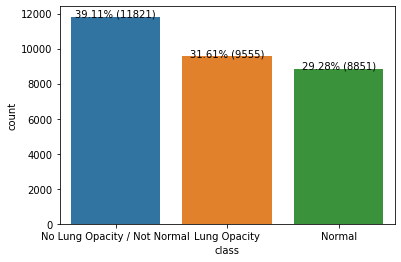

In [11]:
# Check the number of records for each class
print(class_info_df['class'].value_counts())
f, ax = plt.subplots(1,1, figsize=(6,4))
sns.countplot(class_info_df['class'], data=class_info_df, order = class_info_df['class'].value_counts().index)

total = float(len(class_info_df))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}% ({:d})'.format(100*height/total, height),
            ha="center")

plt.show()

# All classes have approximately same number of records

0    20672
1     9555
Name: Target, dtype: int64


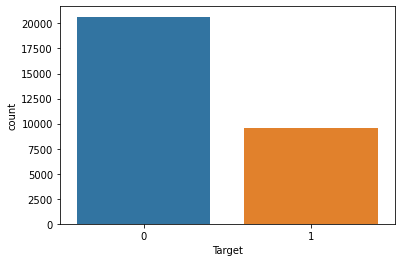

In [12]:
# Check the number of records for each 'Target' value
target_counts = train_labels_df['Target'].value_counts()
print(target_counts)
sns.countplot(train_labels_df['Target'], data=train_labels_df)
# The target value of 0 has twice the number of records as that of 1.
# However, the target value of '0' includes 2 classes - 'No Lung Opacity / Not Normal' & 'Normal'

Identify Missing Data

In [0]:
# Define a function to calculate the percentage of missing values for each of the columns
def count_missing_data(df):
  print('Percentage of missing values for each column:')
  for col in df.columns:
    print(col, ':', df[col].isnull().sum()/len(df[col]))

In [14]:
count_missing_data(class_info_df)
# There are no missing values in the class details df

Percentage of missing values for each column:
patientId : 0.0
class : 0.0


In [15]:
# Check if there is missing data in any columns
count_missing_data(train_labels_df)
# 68.3% of the rows are missing bbox coordinates, ie the x, y, height and width columns

Percentage of missing values for each column:
patientId : 0.0
x : 0.6838918847388097
y : 0.6838918847388097
width : 0.6838918847388097
height : 0.6838918847388097
Target : 0.0


In [16]:
# Check if there are any columns with missing data when the target col is 1, that is when a patient is diagnosed with Pneumonia
count_missing_data(train_labels_df[(train_labels_df['Target']==1)])

# For a patient diagnosed with Pneumonia, none of the columns are missing data.
# All the columns with missing data are from the patients without Pneumonia(both 'Normal' and 'No Lung Opacity / Not Normal')
# 68.3% is the exact number of rows with negative for Pneumonia, which means the bounding boxes are missing only for non-Pneumonia afflicted patients

Percentage of missing values for each column:
patientId : 0.0
x : 0.0
y : 0.0
width : 0.0
height : 0.0
Target : 0.0


In [17]:
# Before merging the two dfs, check if all the patientIds are present in both the class and labels datasets
df_diff = pd.concat([train_labels_df['patientId'],class_info_df['patientId']]).drop_duplicates(keep=False)
print('Number of patientIds in train_labels_df, but not in class_info_df:', len(df_diff))

df_diff = pd.concat([class_info_df['patientId'], train_labels_df['patientId']]).drop_duplicates(keep=False)
print('Number of patientIds in class_info_df, but not in train_labels_df:', len(df_diff))

# All patientIds are present in both the files. 

Number of patientIds in train_labels_df, but not in class_info_df: 0
Number of patientIds in class_info_df, but not in train_labels_df: 0


There are no missing values in Class Info data.

68.3% of the values are missing in the Training Labels data. The missing data is for Target = 0, which includes 'Normal' & 'No Lung Opacity / Not Normal'

In the train set, the percent of data for Target=1 is 31.61%

Merge Train Labels and Class Info details

In [18]:
# Merge the two datasets, using patientId as the key
train_df = pd.merge(class_info_df, train_labels_df, on='patientId', how='inner')
train_df.drop_duplicates(inplace=True)
train_df.shape

(30227, 7)

Text(0, 0.5, 'Exams')

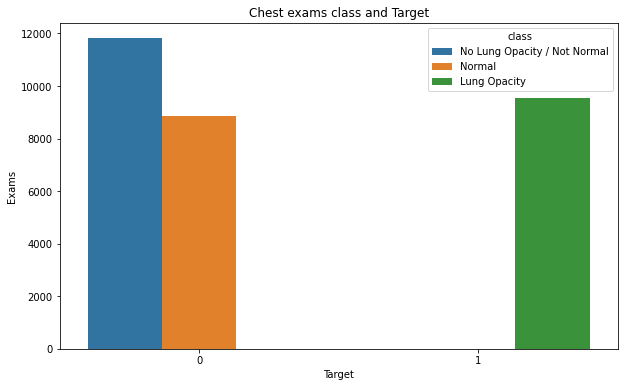

In [19]:
# Plot the number of examinations for each class detected, grouped by Target value.
fig, ax = plt.subplots(nrows=1,figsize=(10,6))
ax = sns.countplot(x='Target', data=train_df, hue='class')
plt.title("Chest exams class and Target")
plt.ylabel("Exams")

All chest exams with Target=1, ie Pneumonia Detected, are associated with Class=Lung Opacity

For Target = 0, ie no Pneumonia Detected, includes 'Normal' & 'No Lung Opacity / Not Normal' classes

Analyze the Lung Opacity Window

<Figure size 432x288 with 0 Axes>

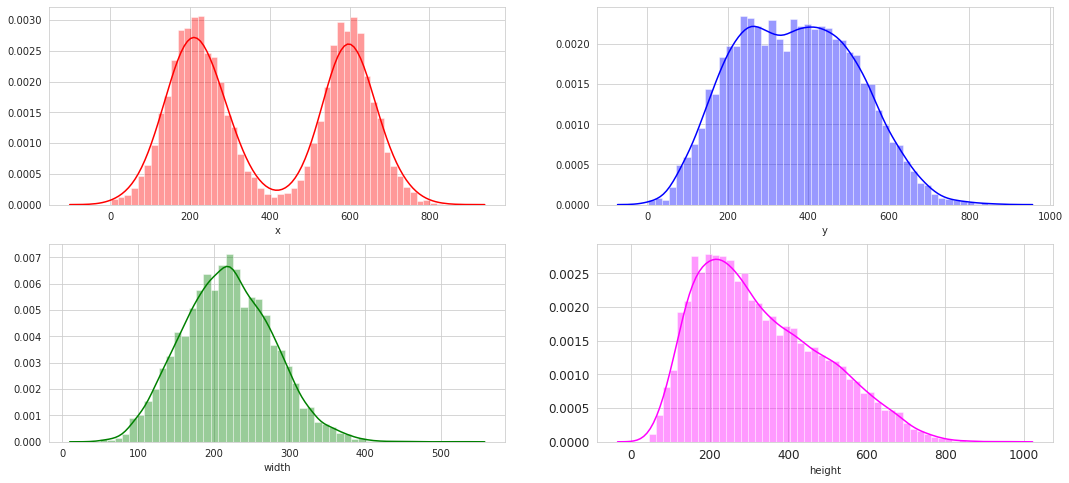

In [20]:
# For the class Lung Opacity, corresponding to values of Target = 1, we plot the density of x, y, width and height.
target1 = train_df[train_df['Target']==1]
sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(2,2,figsize=(18,8))
sns.distplot(target1['x'],kde=True,bins=50, color="red", ax=ax[0,0])
sns.distplot(target1['y'],kde=True,bins=50, color="blue", ax=ax[0,1])
sns.distplot(target1['width'],kde=True,bins=50, color="green", ax=ax[1,0])
sns.distplot(target1['height'],kde=True,bins=50, color="magenta", ax=ax[1,1])
locs, labels = plt.xticks()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

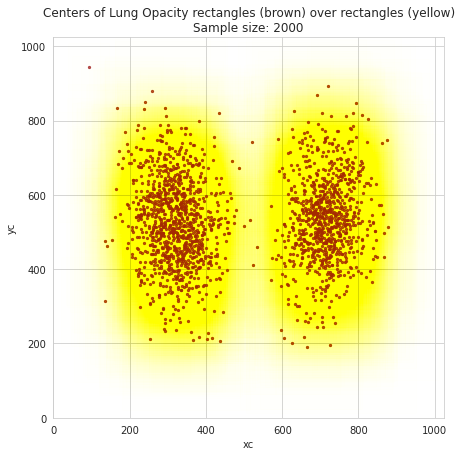

In [21]:
# Plot the centers of rectangles in brown superimposed with the actual bbox rectangle in yellow
fig, ax = plt.subplots(1,1,figsize=(7,7))

target_sample = target1.sample(2000)
target_sample['xc'] = target_sample['x'] + target_sample['width'] / 2 # xmin + width/2 gives the xcenter of the bbox
target_sample['yc'] = target_sample['y'] + target_sample['height'] / 2 # ymin + height/2 gives the ycenter of the bbox

plt.title("Centers of Lung Opacity rectangles (brown) over rectangles (yellow)\nSample size: 2000")
target_sample.plot.scatter(x='xc', y='yc', xlim=(0,1024), ylim=(0,1024), ax=ax, alpha=0.8, marker=".", color="brown")
for i, crt_sample in target_sample.iterrows():
    ax.add_patch(Rectangle(xy=(crt_sample['x'], crt_sample['y']),
                width=crt_sample['width'],height=crt_sample['height'],alpha=3.5e-3, color="yellow"))

plt.show()

Setup Paths for Training and Test Image Datasets

In [22]:
# Set the train and test images directories
train_images_dir = PATH+'stage_2_train_images/'
test_images_dir = PATH+'stage_2_test_images/'
print("Number of images in train set:", len(os.listdir(train_images_dir)),"\nNumber of images in test set:", len(os.listdir(test_images_dir)))

Number of images in train set: 26684 
Number of images in test set: 3000


In [23]:
# Read a sample of datafiles
image_sample_path = os.listdir(train_images_dir)[:5]
print(image_sample_path)

['5a497d5a-808a-4e0b-951a-334efb497229.dcm', '0b574b43-d7ab-4d95-bf13-fded0fb11e43.dcm', '9efec342-ee16-4e7a-907c-c7af82575150.dcm', 'caf813f9-efc0-4a61-93b7-cd9e50bbc595.dcm', '7f4d7003-5743-4747-91d2-87d52ade47e7.dcm']


In [24]:
print("Unique patientId in train_df:", train_df['patientId'].nunique()) # Check for duplicate records in training set
print("Total rows in train_df:", train_df.shape[0])
# Since the total rows are more than the number of patients, we can deduce that there are multiple rows for some patients

Unique patientId in train_df: 26684
Total rows in train_df: 30227


In [25]:
# Let's plot the number of examinations for each class detected, grouped by Target value.
tmp = train_df.groupby(['patientId','Target','class'])['patientId'].count()
df = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index()
tmp = df.groupby(['Exams','Target','class']).count()
df2 = pd.DataFrame(data=tmp.values, index=tmp.index).reset_index()
df2.columns = ['Exams','Target','Class','Entries']
df2

Exams  Target                         Class  Entries
0      1       0  No Lung Opacity / Not Normal    11821
1      1       0                        Normal     8851
2      1       1                  Lung Opacity     2614
3      2       1                  Lung Opacity     3266
4      3       1                  Lung Opacity      119
5      4       1                  Lung Opacity       13

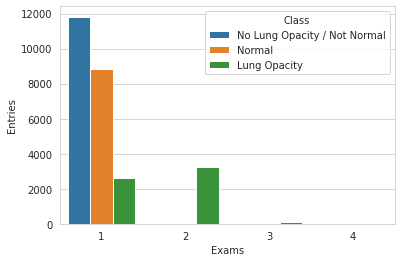

In [26]:
sns.barplot(x=df2['Exams'], y=df2['Entries'], hue=df2['Class'])

Examine the Images

In [27]:
samplePatientID = list(train_df[:3].T.to_dict().values())[0]['patientId']
samplePatientID = samplePatientID+'.dcm'
dicom_file_dataset = pydicom.dcmread(train_images_dir + samplePatientID)
dicom_file_dataset

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 0010) Patient's Name                      PN: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0020) Patient ID                          LO: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient'

In [28]:
# For 500 patients with Pneumonia, get info about their age and gender
# Currently able to get info for only 500 images, as it is taking a long time.
temp_df = train_df[train_df['Target']==1]
img_data = list(temp_df.T.to_dict().values())

# Create empty df to hold patient info
stats_df = pd.DataFrame(columns=['PatientId','Age','Sex'])

# Using pydicom package, access the dataset of each image
for i, data_row in enumerate(img_data[0:500]):
  img_file = data_row['patientId'] + '.dcm'
  img = pydicom.dcmread(train_images_dir + img_file)

  # Append Patient's age and gender info to the df
  stats_df = stats_df.append({'PatientId':img.PatientID, 'Age':int(img.PatientAge), 'Sex':img.PatientSex}, ignore_index=True)
  
len(stats_df)

500

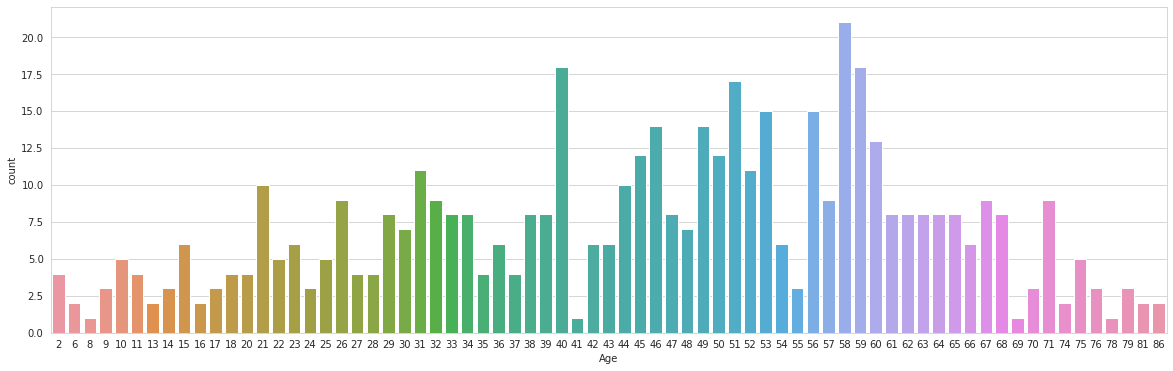

In [29]:
# Plot the frequency of patients with Pneumonia in each age group
plt.figure(1, figsize=(20,6))
sns.countplot(stats_df['Age'])

# Number of Pneumonia patients is large between age groups of 40 to 60

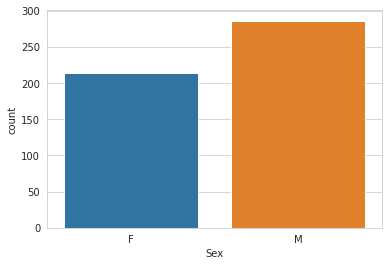

In [30]:
# Plot count of patients with Pneumonia by gender
sns.countplot(stats_df['Sex'])

# Number of males suffering from pneumonia is greater than females

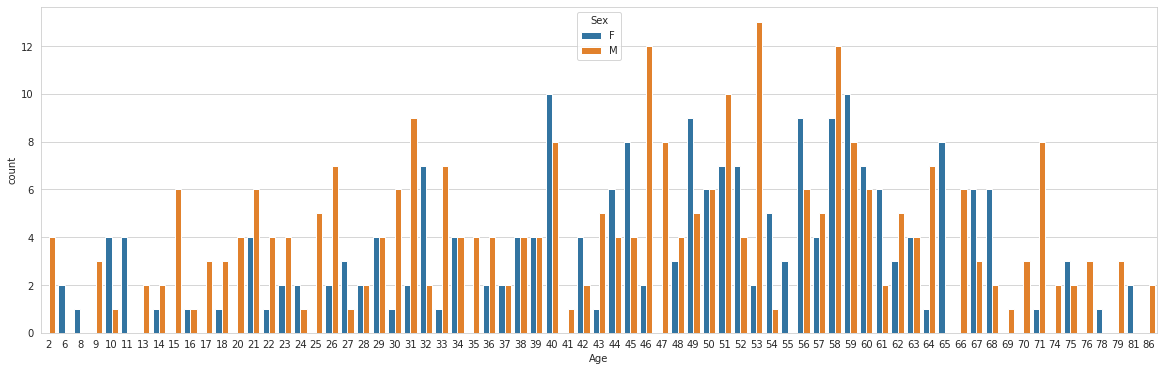

In [31]:
# Compare freq of patients with Pneumonia by gender and Age
plt.figure(1, figsize=(20,6))
sns.countplot(stats_df['Age'], hue=stats_df['Sex'])

Plot Dicom Images with Target=1

In [0]:
def show_dicom_images(data):
  img_data = list(data.T.to_dict().values())

  fig, ax = plt.subplots(3,3,figsize=(16,18))

  for i, data_row in enumerate(img_data):
    img_file = data_row['patientId'] + '.dcm'
    img = pydicom.dcmread(train_images_dir + img_file)
    
    modality = img.Modality
    age = img.PatientAge
    sex = img.PatientSex

    ax[i//3, i%3].imshow(img.pixel_array, cmap=plt.cm.bone)
    ax[i//3, i%3].axis('off')
    ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}\nWindow: {}:{}:{}:{}'.format(
                data_row['patientId'], modality, age, sex, data_row['Target'], data_row['class'], 
                data_row['x'],data_row['y'],data_row['width'],data_row['height']))

  plt.show()

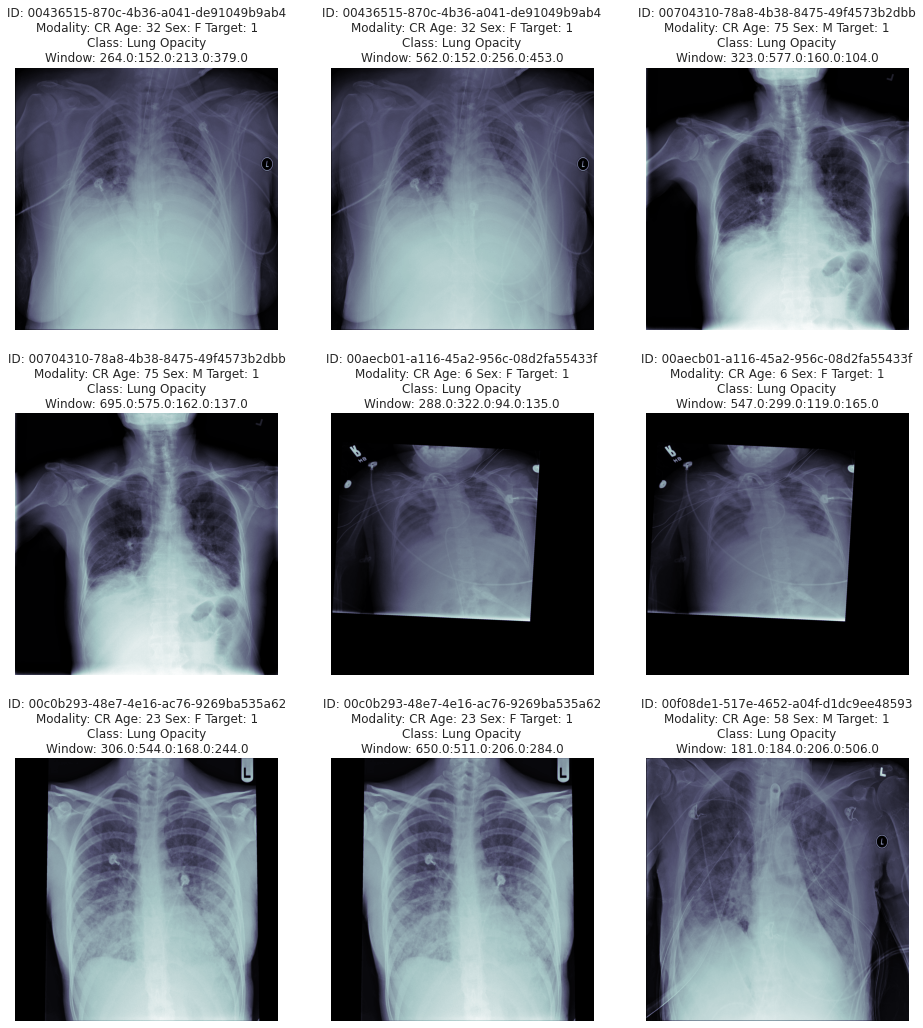

In [33]:
show_dicom_images(train_df[train_df['Target']==1].head(9))

In [0]:
def show_dicom_images_with_boxes(data):
  img_data = list(data.T.to_dict().values())

  f, ax = plt.subplots(3, 3, figsize=(16,18))

  for i, data_row in enumerate(img_data):
    img_file = data_row['patientId'] + '.dcm'
    img = pydicom.dcmread(train_images_dir + img_file)

    modality = img.Modality
    age = img.PatientAge
    sex = img.PatientSex

    ax[i//3, i%3].imshow(img.pixel_array, cmap=plt.cm.bone)
    ax[i//3, i%3].axis('off')
    ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}\nWindow: {}:{}:{}:{}'.format(
                data_row['patientId'], modality, age, sex, data_row['Target'], data_row['class'], 
                data_row['x'],data_row['y'],data_row['width'],data_row['height']))

    rows = train_df[train_df['patientId']==data_row['patientId']]
    box_data = list(rows.T.to_dict().values())
    for j, row in enumerate(box_data):
        ax[i//3, i%3].add_patch(Rectangle(xy=(row['x'], row['y']),
                    width=row['width'],height=row['height'], 
                    color="blue",alpha = 0.1))   

  plt.show()

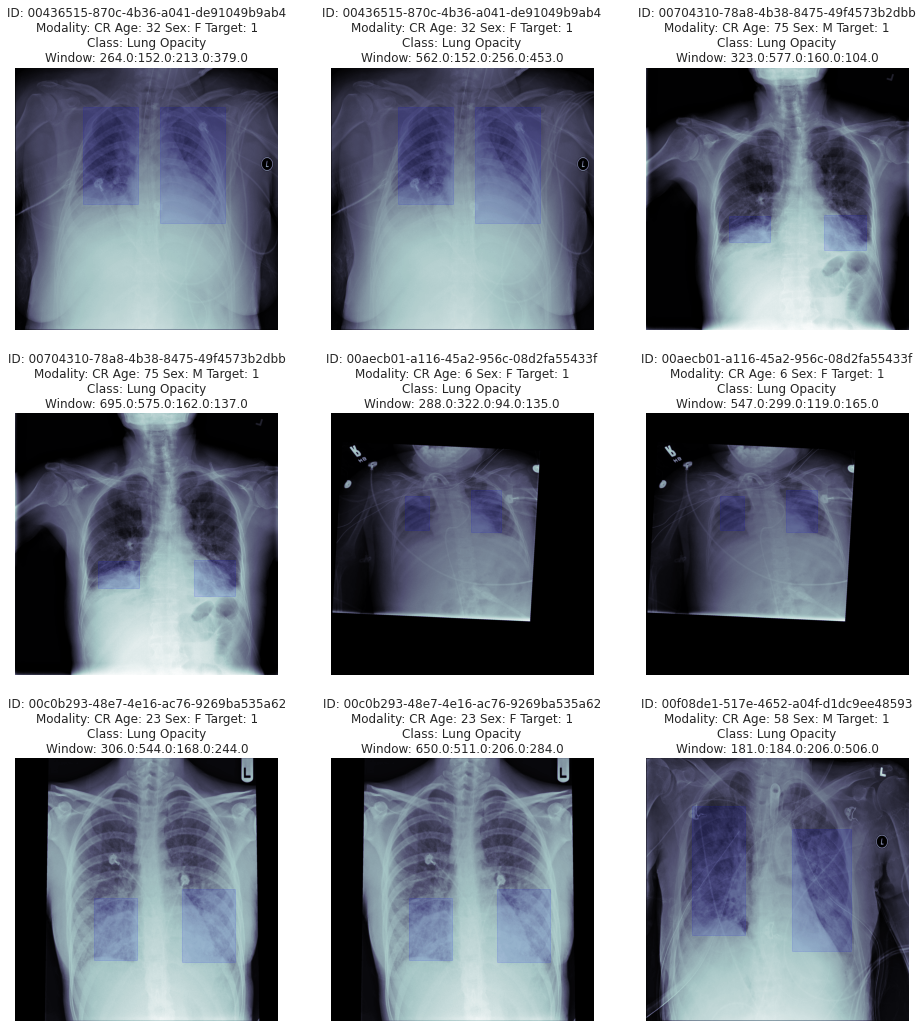

In [35]:
show_dicom_images_with_boxes(train_df[train_df['Target']==1].head(9))

Plot DICOM Images with Target=0

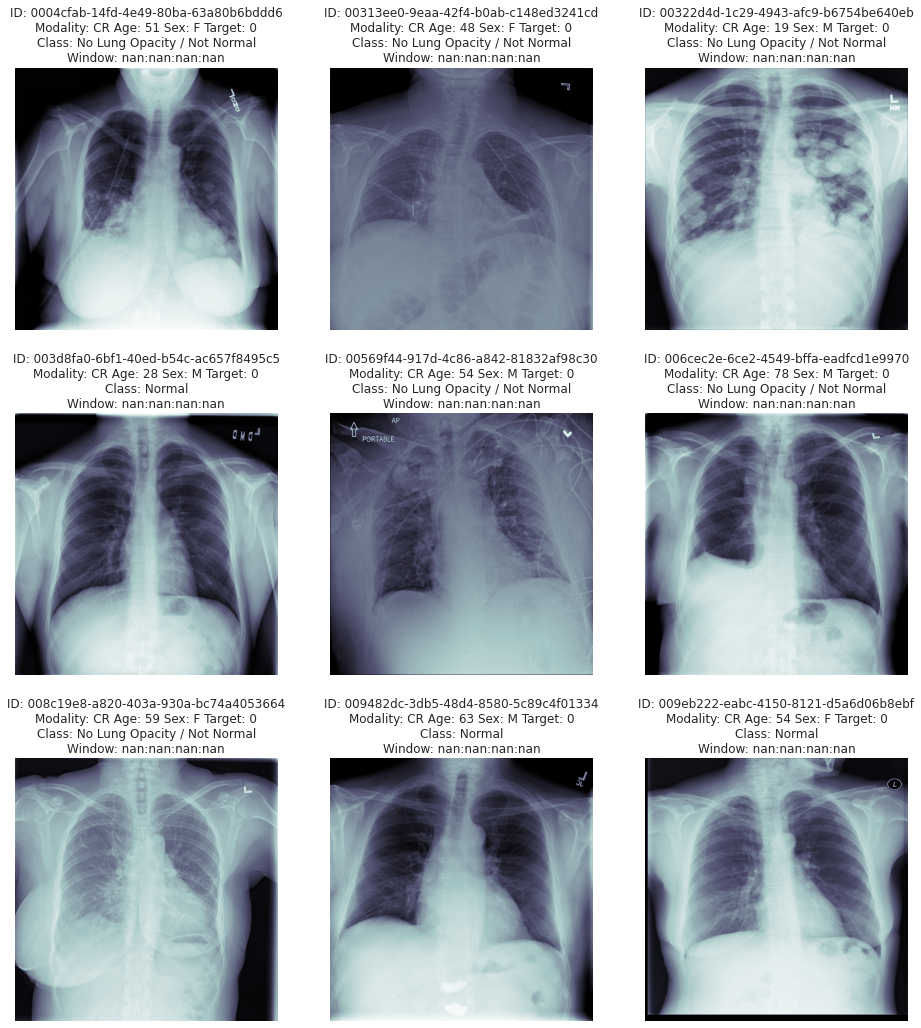

In [36]:
# Since CXR images of patients with no Pneumonia do not have opacities, we do not display bounding boxes
show_dicom_images(train_df[train_df['Target']==0].head(9))

##Data Preprocessing

In [0]:
# Define the model parameters
IMAGE_SIZE = 256
BATCH_SIZE = 32 # Depends on your GPU or CPU RAM.

In [0]:
# Store all bbox coordinates for pneumonia patches in a dictionary
pneumonia_locations = {}

for i, row in train_labels_df.iterrows():
  filename = row[0]
  location = row[1:5]
  pneumonia = row[5]

  # If pneumonia is present, add patientId and coordinates to dict. 
  if pneumonia == 1:
    location = [int(float(i)) for i in location]

    if filename in pneumonia_locations:
      pneumonia_locations[filename].append(location) # If there are multiple bboxs for one patient, each set is stored as a sublist
    else:
      pneumonia_locations[filename] = [location]

In [39]:
# Load and Shuffle filenames
import random
folder = PATH+'stage_2_train_images/'
filenames = os.listdir(folder)
random.shuffle(filenames)

# Split into train and validation filenames
n_valid_samples = 2500
train_filenames = filenames[n_valid_samples:]
valid_filenames = filenames[:n_valid_samples]
print('n train samples:', len(train_filenames))
print('n test samples:', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples

print('Total Train Images =', len(filenames))
print('Images with Pneumonia =', len(pneumonia_locations))

n train samples: 24184
n test samples: 2500
Total Train Images = 26684
Images with Pneumonia = 6012


In [0]:
# Data Generator for CLASSIFICATION using Sequence for multiprocessing
import math
from skimage.transform import resize
from tensorflow.keras.utils import Sequence

class ClassificationDataGenerator(Sequence):
  def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=True, augment=False, predict=False):
    self.folder = folder
    self.filenames = filenames
    self.pneumonia_locations = pneumonia_locations
    self.batch_size = batch_size
    self.image_size = image_size
    self.shuffle = shuffle
    self.augment = augment
    self.predict = predict
    self.on_epoch_end()

  def __load__(self, filename):
    # Load DICOM file as numpy array
    img = pydicom.dcmread(self.folder + filename).pixel_array
    filename = filename.split('.')[0] # Remove the file extension
    if filename in pneumonia_locations:
      tgt = 1 # Has Pneumonia
    else:
      tgt = 0 # Does not have Pneumonia

    # If augment flag is on, then flip the image and mask horizontally half the times
    if self.augment and random.random() > 0.5:
      img = np.fliplr(img)

    # Resize the image
    img = resize(img, (self.image_size, self.image_size), mode='symmetric')
    # Add the channel dimension to the image files
    img = np.expand_dims(img, -1)

    return img, tgt

  def __loadpredict__(self, filename):
    # Load DICOM file as numpy array
    img = pydicom.dcmread(self.folder + filename).pixel_array
    img = resize(img, (self.image_size, self.image_size), mode='symmetric')
    img = np.expand_dims(img, -1)
    return img

  def __getitem__(self, idx):
    # select batch
    filenames = self.filenames[idx*self.batch_size : (idx + 1)*self.batch_size] # Image path

    if self.predict:
      # Load files for this batch
      imgs = [self.__loadpredict__(filename) for filename in filenames]    
      imgs = np.array(imgs) # Create numpy arrays for batch images
      return imgs, filenames
    else:
      # Load files for this batch
      items = [self.__load__(filename) for filename in filenames] 
      imgs, tgts = zip(*items) # Output of __load__ is a tuple with imgs and targets, so Unzip the images and masks
      imgs = np.array(imgs)    # Create numpy arrays for batch images
      tgts = np.array(tgts)    # Create numpy arrays for targets
      return imgs, tgts

  def on_epoch_end(self):
    if self.shuffle:
      random.shuffle(self.filenames)

  def __len__(self):
    if self.predict:
      return int(np.ceil(len(self.filenames) / self.batch_size))
    else:
      return int(len(self.filenames) / self.batch_size)

In [0]:
# Data Generator for REGRESSION using Sequence for multiprocessing
import math
from skimage.transform import resize
from tensorflow.keras.utils import Sequence

class DataSequence(Sequence):
  def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=True, augment=False, predict=False):
    self.folder = folder
    self.filenames = filenames
    self.pneumonia_locations = pneumonia_locations
    self.batch_size = batch_size
    self.image_size = image_size
    self.shuffle = shuffle
    self.augment = augment
    self.predict = predict
    self.on_epoch_end()

  def __load__(self, filename):
    # Load DICOM file as numpy array
    img = pydicom.dcmread(self.folder + filename).pixel_array

    # Create empty mask
    mask = np.zeros(img.shape)
    filename = filename.split('.')[0] # Remove the file extension
    if filename in pneumonia_locations:
      for location in pneumonia_locations[filename]:
        x, y, width, height = location
        mask[x:x+width, y:y+height] = 1 # Broadcast value of 1 to all the pixels within the bbox coordinates

    # If augment flag is on, then flip the image and mask horizontally half the times
    if self.augment and random.random() > 0.5:
      img = np.fliplr(img)
      mask = np.fliplr(mask)

    # Resize both the image and mask
    img = resize(img, (self.image_size, self.image_size), mode='symmetric')
    mask = resize(mask, (self.image_size, self.image_size), mode='symmetric') > 0.5

    # Add the channel dimension to both the image and masks files
    img = np.expand_dims(img, -1)
    mask = np.expand_dims(mask, -1)

    return img, mask

  def __loadpredict__(self, filename):
    # Load DICOM file as numpy array
    img = pydicom.dcmread(self.folder + filename).pixel_array
    img = resize(img, (self.image_size, self.image_size), mode='symmetric')
    img = np.expand_dims(img, -1)
    return img

  def __getitem__(self, idx):
    # select batch
    filenames = self.filenames[idx*self.batch_size : (idx + 1)*self.batch_size] # Image path

    if self.predict:
      # Load files for this batch
      imgs = [self.__loadpredict__(filename) for filename in filenames]    
      imgs = np.array(imgs) # Create numpy arrays for batch images
      return imgs, filenames
    else:
      # Load files for this batch
      items = [self.__load__(filename) for filename in filenames] 
      imgs, msks = zip(*items) # Output of __load__ is a tuple with imgs and masks, so Unzip the images and masks
      imgs = np.array(imgs)    # Create numpy arrays for batch images
      msks = np.array(msks)    # Create numpy arrays for batch masks
      return imgs, msks

  def on_epoch_end(self):
    if self.shuffle:
      random.shuffle(self.filenames)

  def __len__(self):
    if self.predict: # return everything
      return int(np.ceil(len(self.filenames) / self.batch_size))
    else: # return batches of size = BATCH_SIZE
      return int(len(self.filenames) / self.batch_size)

In [0]:
# Define IOU or Jaccard Loss function
def iou_loss(y_true, y_pred): 
  y_true = tf.reshape(y_true, [-1]) 
  y_pred = tf.reshape(y_pred, [-1])
  intersection = tf.reduce_sum(y_true * y_pred) 
  score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.) 
  return 1 - score

# Combine BCE Loss and IOU Loss 
def iou_bce_loss(y_true, y_pred): 
  return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred) 

# Mean IOU as a metric 
def mean_iou(y_true, y_pred): 
  y_pred = tf.round(y_pred) 
  intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3]) 
  union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3]) 
  smooth = tf.ones(tf.shape(intersect)) 
  return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth)) 

##Model Creation

In [43]:
# Import necessary packages
import tensorflow as tf
from tensorflow import keras
from skimage import measure
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, SeparableConv2D, UpSampling2D
from keras.layers import Dense, Flatten, Dropout, BatchNormalization, Input, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

Using TensorFlow backend.


###Classification model to predict presence of Pneumonia

In [0]:
# CLASSIFICATION MODEL
inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))

# First conv block
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Second conv block
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Third conv block
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Fourth conv block
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Fifth conv block
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# FC layer
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Output layer
output = Dense(units=1, activation='sigmoid')(x)

# Creating model and compiling
classifier = Model(inputs=inputs, outputs=output)
classifier.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 16)      160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 128, 128, 32)      688       
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 128, 128, 32)      1344      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128 

In [0]:
# Compile classification model and track class level metrics apart from accuracy
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC(), tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives(), tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives()])

In [0]:
# Define Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights_class.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=1, verbose=2, mode='max')

In [0]:
# Generate training and validation datasets for Classification Model
folder = PATH +'stage_2_train_images/'
class_train_gen = ClassificationDataGenerator(folder, train_filenames, pneumonia_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=False, predict=False, augment=True)
class_valid_gen = ClassificationDataGenerator(folder, valid_filenames, pneumonia_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=False, predict=False) 

In [0]:
# Train the classification model
class_history = classifier.fit_generator(class_train_gen, validation_data=class_valid_gen, epochs=5, callbacks=[checkpoint, lr_reduce], verbose=1, shuffle=True)

# Accuracy and class level metrics captured per epoch

Epoch 1/5
755/755 [==============================] - 1724s 2s/step - loss: 0.4719 - accuracy: 0.7846 - precision: 0.5255 - recall: 0.1252 - auc: 0.7116 - true_positives: 402.1126 - true_negatives: 9044.6514 - false_positives: 328.8636 - false_negatives: 2320.3721 - val_loss: 0.5244 - val_accuracy: 0.7865 - val_precision: 0.5662 - val_recall: 0.1874 - val_auc: 0.7428 - val_true_positives: 1072.7307 - val_true_negatives: 18876.8340 - val_false_positives: 821.8461 - val_false_negatives: 4652.5898
Epoch 2/5
755/755 [==============================] - 1699s 2s/step - loss: 0.4499 - accuracy: 0.7957 - precision: 0.5779 - recall: 0.2144 - auc: 0.7494 - true_positives: 1888.2954 - true_negatives: 28659.9199 - false_positives: 1373.4729 - false_negatives: 6830.2939 - val_loss: 0.3995 - val_accuracy: 0.7776 - val_precision: 0.5851 - val_recall: 0.2278 - val_auc: 0.7591 - val_true_positives: 2671.3462 - val_true_negatives: 38455.5508 - val_false_positives: 1894.1282 - val_false_negatives: 9058.974

In [0]:
from keras.models import model_from_yaml

# Serialize classification model to YAML
class_yaml = classifier.to_yaml()
with open(project_path+"class_model3.yaml", "w") as yaml_file:
    yaml_file.write(class_yaml)
# Serialize weights to HDF5
classifier.save_weights(project_path+"class_model3_weights.h5")
print("Saved classifier model to disk")

Saved classifier model to disk


In [0]:
# Gather training Loss, Accuracy and other class level metrics
df_classi_metrics = pd.DataFrame(columns=['Model','Epoch','Train loss','Valid loss','Train accuracy','Valid accuracy','Train Precision','Valid Precision','Train Recall','Valid Recall','Train AUC','Valid AUC','Train True Positives','Train True Negatives','Train False Positives','Train False Negatives','Valid True Positives','Valid True Negatives','Valid False Positives','Valid False Negatives'])
for i, epoch_num in enumerate(class_history.epoch):
  df_classi_metrics = df_classi_metrics.append({
                    'Model':'Classification Model',
                    'Epoch': int(epoch_num),
                    'Train loss':class_history.history["loss"][i],
                    'Valid loss':class_history.history["val_loss"][i],
                    'Train accuracy':class_history.history["accuracy"][i],
                    'Valid accuracy':class_history.history["val_accuracy"][i],
                    'Train Precision':class_history.history['precision'][i],
                    'Valid Precision':class_history.history["val_precision"][i],
                    'Train Recall':class_history.history['recall'][i],
                    'Valid Recall':class_history.history["val_recall"][i],
                    'Train AUC':class_history.history['auc'][i],
                    'Valid AUC':class_history.history["val_auc"][i],
                    'Train True Positives':class_history.history['true_positives'][i], 
                    'Train True Negatives':class_history.history['true_negatives'][i],
                    'Train False Positives':class_history.history['false_positives'][i],
                    'Train False Negatives':class_history.history['false_negatives'][i],
                    'Valid True Positives':class_history.history['val_true_positives'][i],  
                    'Valid True Negatives':class_history.history['val_true_negatives'][i],
                    'Valid False Positives':class_history.history['val_false_positives'][i],
                    'Valid False Negatives':class_history.history['val_false_negatives'][i]},
                    ignore_index=True)
  
df_classi_metrics.to_csv(project_path + 'classification_metrics.csv')
df_classi_metrics

Model Epoch  ...  Valid False Positives  Valid False Negatives
0  Classification Model     0  ...             821.846130            4652.589844
1  Classification Model     1  ...            1894.128174            9058.974609
2  Classification Model     2  ...            3178.487061           12874.127930
3  Classification Model     3  ...            4612.077148           16333.756836
4  Classification Model     4  ...            5962.346191           19824.884766

[5 rows x 20 columns]

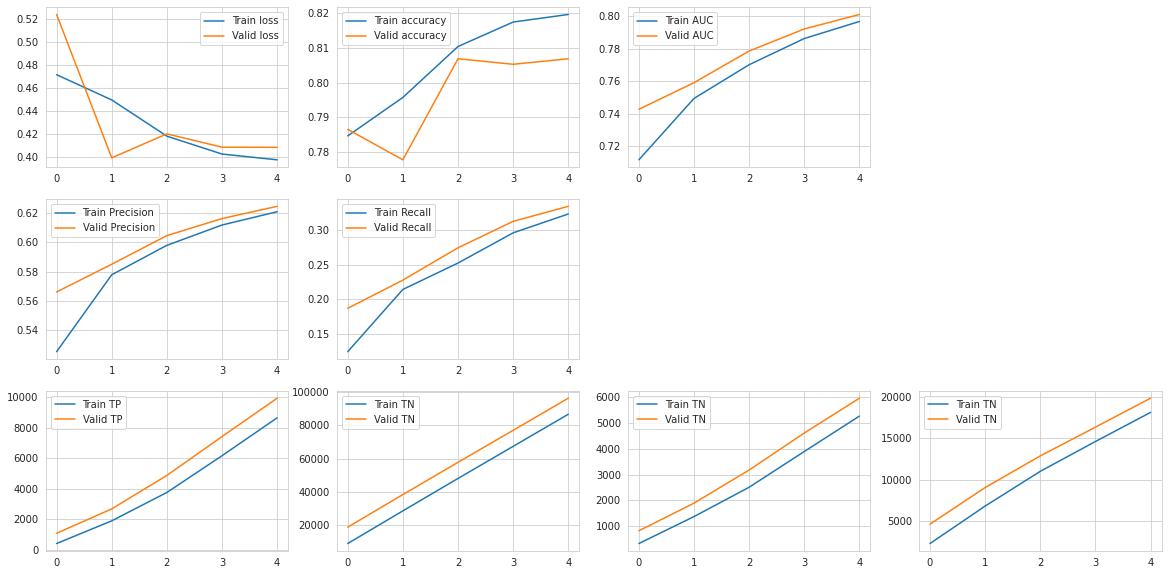

In [0]:
history = class_history

plt.figure(figsize=(20,10)) 
plt.subplot(341) 
plt.plot(history.epoch, history.history["loss"], label="Train loss") 
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss") 
plt.legend() 
plt.subplot(342) 
plt.plot(history.epoch, history.history["accuracy"], label="Train accuracy") 
plt.plot(history.epoch, history.history["val_accuracy"], label="Valid accuracy") 
plt.legend() 
plt.subplot(343) 
plt.plot(history.epoch, history.history['auc'], label="Train AUC") 
plt.plot(history.epoch, history.history["val_auc"], label="Valid AUC")
plt.legend()
plt.subplot(345) 
plt.plot(history.epoch, history.history['precision'], label="Train Precision") 
plt.plot(history.epoch, history.history["val_precision"], label="Valid Precision")
plt.legend()
plt.subplot(346) 
plt.plot(history.epoch, history.history['recall'], label="Train Recall") 
plt.plot(history.epoch, history.history["val_recall"], label="Valid Recall")
plt.legend()
plt.subplot(349)
plt.plot(history.epoch, history.history["true_positives"], label="Train TP") 
plt.plot(history.epoch, history.history["val_true_positives"], label="Valid TP") 
plt.legend()
plt.subplot(3,4,10)
plt.plot(history.epoch, history.history["true_negatives"], label="Train TN") 
plt.plot(history.epoch, history.history["val_true_negatives"], label="Valid TN") 
plt.legend()
plt.subplot(3,4,11)
plt.plot(history.epoch, history.history["false_positives"], label="Train TN") 
plt.plot(history.epoch, history.history["val_false_positives"], label="Valid TN") 
plt.legend()
plt.subplot(3,4,12)
plt.plot(history.epoch, history.history["false_negatives"], label="Train TN") 
plt.plot(history.epoch, history.history["val_false_negatives"], label="Valid TN") 
plt.legend()
plt.show() 

In [0]:
# Load classification YAML and create model
with open(project_path + 'class_model3.yaml', 'r') as yaml_file:
  loaded_model_yaml = yaml_file.read()
loaded_class_model3 = model_from_yaml(loaded_model_yaml)
# Load weights into new model
loaded_class_model3.load_weights(project_path + "class_model3_weights.h5")
print("Loaded classification model from disk")

# loaded_class_model3.summary()

Loaded classification model from disk


In [0]:
# Generate the test data for the entire testdata
folder = PATH + 'stage_2_test_images/'
test_filenames = os.listdir(folder)
print('n test samples', len(test_filenames))

# Set predict=True so the entire dataset is returned at once
class_test_gen = ClassificationDataGenerator(folder, test_filenames, pneumonia_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=False, predict=True) 

n test samples 3000


In [0]:
# Create submission dictionary
class_preds_dict = {}
# Loop through testset
for imgs, filenames in class_test_gen:
    # predict batch of images
    preds = classifier.predict(imgs)
    # loop through batch
    for pred, filename in zip(preds, filenames):
        # add filename and predictionString to dictionary
        filename = filename.split('.')[0]
        class_preds_dict[filename] = pred
    # stop if we've got them all
    if len(class_preds_dict) >= len(test_filenames):
        break

# Save dictionary as csv file
sub = pd.DataFrame.from_dict(class_preds_dict, orient='index')
sub.index.names = ['patientId']
sub.columns = ['hasPneumonia']
sub.to_csv(project_path + 'PneumoniaClassPrediction.csv')

# Creates a class prediction file

In [0]:
sub.head()

hasPneumonia
patientId                                         
1f5f2bb2-acc2-4c18-b6d5-212f9a9980b5      0.581347
0cfcd755-5c79-4fcd-9562-0b983f77d0c0      0.090041
1a0309e4-762b-4b64-9e2c-0f16dc4d5381      0.253197
2b9990c6-dd10-44e4-9d5a-5701a964a57d      0.067803
0066ba32-08b6-4ac9-8d5a-abec69825d53      0.565425

###Object Detection Models to predict bbox coordinates

####Model 1 - Conv2D and Upsampling2D

In [61]:
# Model 1 with Conv2D Layers
model1 = Sequential()

# Add Convolution layers with 32 kernels of 3X3 shape with activation function ReLU
model1.add(Conv2D(4, (3, 3), input_shape = (IMAGE_SIZE, IMAGE_SIZE, 1), activation = 'relu', padding = 'same'))
model1.add(MaxPooling2D(pool_size = (2, 2))) # Max Pooling layer of size 2X2

model1.add(Conv2D(16, (2, 2), activation = 'relu', padding = 'same'))
model1.add(MaxPooling2D(pool_size = (2, 2)))
model1.add(BatchNormalization())

model1.add(Conv2D(64, (2, 2), activation = 'relu', padding = 'same'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size = (2, 2)))
model1.add(Dropout(0.4))

model1.add(Conv2D(128, (2, 2), activation = 'relu', padding = 'same'))
model1.add(MaxPooling2D(pool_size = (2, 2)))
model1.add(Dropout(0.3))

# 1 unit with Sigmoid activation for binary classification
model1.add(Conv2D(1, 1, activation='sigmoid'))

# UpSampling Layer to bring the image back to the input size
model1.add(UpSampling2D(16))

model1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 256, 256, 4)       40        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 128, 128, 4)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 128, 128, 16)      272       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 64, 64, 16)        64        
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 64)        4160      
_________________________________________________________________
batch_normalization_4 (Batch (None, 64, 64, 64)       

In [0]:
# Compile the model
model1.compile(optimizer='adam', loss=iou_bce_loss, metrics=['accuracy', mean_iou, tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

In [0]:
# Define Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=2, mode='max')

In [0]:
#create train and validation generators 
folder = PATH+'./stage_2_train_images' 

train_gen = DataSequence(folder, train_filenames, pneumonia_locations, batch_size=32, image_size=256, shuffle=False, predict=False, augment= True)
valid_gen = DataSequence(folder, valid_filenames, pneumonia_locations, batch_size=32, image_size=256, shuffle=False, predict=False) 

In [0]:
# Fit the model
#history = model_1.fit_generator(train_gen, validation_data=valid_gen, callbacks=[checkpoint, lr_reduce], epochs=5, shuffle=True, verbose=1) 

In [0]:
# model1 Save model in yaml format
from keras.models import model_from_yaml

# Serialize model to YAML
model_yaml = model1.to_yaml()
with open(project_path+"model_1.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# Serialize weights to HDF5
model1.save_weights(project_path+"model_1.h5")
print("Saved regression model to disk")

In [0]:
# Get Training Loss, Accuracy from model history
df_regr_metrics = pd.DataFrame(columns=['Model','Epoch','Train loss','Valid loss','Train accuracy','Valid accuracy','Train iou','Valid iou','Train Precision','Valid Precision','Train Recall','Valid Recall','Train AUC','Valid AUC'])
for i, epoch_num in enumerate(history.epoch):
  df_regr_metrics = df_regr_metrics.append({
                    'Model':'Model1',
                    'Epoch': int(epoch_num),
                    'Train loss':history.history["loss"][i],
                    'Valid loss':history.history["val_loss"][i],
                    'Train accuracy':history.history["accuracy"][i],
                    'Valid accuracy':history.history["val_accuracy"][i],
                    'Train iou':history.history["mean_iou"][i],
                    'Valid iou':history.history["val_mean_iou"][i],
                    'Train Precision':history.history['precision'][i],
                    'Valid Precision':history.history["val_precision"][i],
                    'Train Recall':history.history['recall'][i],
                    'Valid Recall':history.history["val_recall"][i],
                    'Train AUC':history.history['auc'][i],
                    'Valid AUC':history.history["val_auc"][i]}, ignore_index=True)
# saving the dataframe   
df_regr_metrics.to_csv(PATH + 'model1_regr_metrics.csv') 

df_regr_metrics

In [76]:
# Load regression YAML and create model
from keras.models import model_from_yaml
with open(project_path + 'model_1.yaml', 'r') as yaml_file:
  loaded_model_yaml = yaml_file.read()
loaded_regr_model1 = model_from_yaml(loaded_model_yaml)
# Load weights into new model
loaded_regr_model1.load_weights(project_path + "model_1.h5")
print("Loaded regression model from disk")

# loaded_regr_model1.summary()

Loaded regression model from disk


####Model 2 - SeperableConv2D and Upsampling2D

In [49]:
# Model 2 with SeperableConv2D Layers
model2 = Sequential() # Create and instance of Sequential Model

model2.add(Conv2D(filters=16, kernel_size=(2,2), input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1), activation='relu', padding='same'))
model2.add(MaxPooling2D(pool_size = (2, 2)))

model2.add(SeparableConv2D(filters=32, kernel_size=(2,2), activation='relu', padding='same'))
model2.add(MaxPooling2D(pool_size = (2, 2)))

model2.add(SeparableConv2D(filters=64, kernel_size=(2,2), activation='relu', padding='same'))
model2.add(MaxPooling2D(pool_size = (2, 2)))

model2.add(SeparableConv2D(filters=128, kernel_size=(2,2), activation='relu', padding='same'))
model2.add(MaxPooling2D(pool_size = (2, 2)))

model2.add(SeparableConv2D(filters=256, kernel_size=(2,2), activation='relu', padding='same'))
model2.add(MaxPooling2D(pool_size = (2, 2)))

model2.add(SeparableConv2D(filters=256, kernel_size=(2,2), activation='relu', padding='same'))
model2.add(BatchNormalization(momentum=0.9))
model2.add(MaxPooling2D(pool_size = (2, 2)))

model2.add(Conv2D(1, 1, activation='sigmoid'))

model2.add(UpSampling2D())
model2.add(UpSampling2D())
model2.add(UpSampling2D())
model2.add(UpSampling2D())
model2.add(UpSampling2D())
model2.add(UpSampling2D())

model2.summary()

# Compile model using Adam optimizer, combination of BCE and IOU loss, and monitor model performance using accuracy and average IOU
model2.compile(optimizer='adam', loss=iou_bce_loss, metrics=['accuracy', mean_iou, tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 16)      80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 128, 128, 32)      608       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 64, 64, 64)        2240      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
separable_conv2d_3 (Separabl (None, 32, 32, 128)      

In [0]:
# Define Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=1, verbose=2, mode='max')

In [0]:
# Generate training and validation datasets for Regression Model
folder = PATH +'stage_2_train_images/'
train_gen = DataSequence(folder, train_filenames, pneumonia_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=False, predict=False, augment=True)
valid_gen = DataSequence(folder, valid_filenames, pneumonia_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=False, predict=False) 

In [0]:
# Fit Model3
#history2 = model2.fit_generator(train_gen, validation_data=valid_gen, epochs=5, callbacks=[checkpoint, lr_reduce], verbose=1, shuffle=True)
model2.save('/content/drive/My Drive/caption project/model_2_5.h5')

In [0]:
# Save model in yaml format
from keras.models import model_from_yaml

# Serialize model to YAML
model_yaml = model2.to_yaml()
with open(project_path+"model_2_5.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# Serialize weights to HDF5
model2.save_weights(project_path+"model2_weights.h5")
print("Saved regression model to disk")

In [0]:
# Get Training Loss, Accuracy from model history
df_regr_metrics = pd.DataFrame(columns=['Model','Epoch','Train loss','Valid loss','Train accuracy','Valid accuracy','Train iou','Valid iou','Train Precision','Valid Precision','Train Recall','Valid Recall','Train AUC','Valid AUC'])
history = history2
for i, epoch_num in enumerate(history.epoch):
  df_regr_metrics = df_regr_metrics.append({
                    'Model':'Model2',
                    'Epoch': int(epoch_num),
                    'Train loss':history.history["loss"][i],
                    'Valid loss':history.history["val_loss"][i],
                    'Train accuracy':history.history["accuracy"][i],
                    'Valid accuracy':history.history["val_accuracy"][i],
                    'Train iou':history.history["mean_iou"][i],
                    'Valid iou':history.history["val_mean_iou"][i],
                    'Train Precision':history.history['precision'][i],
                    'Valid Precision':history.history["val_precision"][i],
                    'Train Recall':history.history['recall'][i],
                    'Valid Recall':history.history["val_recall"][i],
                    'Train AUC':history.history['auc'][i],
                    'Valid AUC':history.history["val_auc"][i]}, ignore_index=True)

df_regr_metrics.to_csv(project_path+ 'model2_regr_metrics.csv')

df_regr_metrics

In [52]:
# Load regression YAML and create model
with open(project_path + 'model_2_5.yaml', 'r') as yaml_file:
  loaded_model_yaml = yaml_file.read()
loaded_regr_model2 = model_from_yaml(loaded_model_yaml)
# Load weights into new model
loaded_regr_model2.load_weights(project_path + "model_2_5.h5")
print("Loaded regression model from disk")

# loaded_regr_model2.summary()

Loaded regression model from disk


####Model 4 - Resblocks

In [0]:
def create_downsample(channels, inputs): 
  x = keras.layers.BatchNormalization(momentum=0.9)(inputs) 
  x = keras.layers.LeakyReLU(0)(x) 
  x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x) 
  x = keras.layers.MaxPool2D(2)(x) 
  # Added start 
  #x = keras.loyers.Conv2D(channeLs, 1, padding.'same', use bias-FaLse)(x) 
  #x = keras.loyers.MaxPooL20(2)(x) 
  # Added End 
  return x 

def create_resblock(channels, inputs): 
  x = keras.layers.BatchNormalization(momentum=0.9)(inputs) 
  x = keras.layers.LeakyReLU(0)(x) 
  x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x) 
  x = keras.layers.BatchNormalization(momentum=0.9)(x) 
  x = keras.layers.LeakyReLU(0)(x) 
  x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
  
  #Added Start 
  x = keras.layers.BatchNormalization(momentum=0.9)(x) 
  x = keras.layers.LeakyReLU(0)(x) 
  x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x) 
  #Added End

  addInput = x; 
  print("Add input shape:", addInput.shape) 
  print("Resnet block input shape:", inputs.shape) 
  resBlockOut = keras.layers.add([addInput, inputs]) 
  print("Resnet block out shape:", resBlockOut.shape) 
  out = keras.layers.concatenate([resBlockOut, addInput], axis=3) 
  print("concat block out shape:", out.shape) 
  out = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(out) 
  print("mixed block out shape:", out.shape) 
  return out 

def create_network(input_size, channels, n_blocks=2, depth=4): 
  # input 
  inputs = keras.Input(shape=(input_size, input_size, 1)) 
  x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs) 
  # residuaL bLocks 
  for d in range(depth): 
    channels = channels * 2 
    x = create_downsample(channels, x) 
    for b in range(n_blocks): 
      x = create_resblock(channels, x) 
  # output 
  x = keras.layers.BatchNormalization(momentum=0.9)(x)
  x = keras.layers.LeakyReLU(0)(x) 
  x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x) 
  outputs = keras.layers.UpSampling2D(2**depth)(x) 
  model = keras.Model(inputs=inputs, outputs=outputs) 
  return model

In [45]:
# create network and compiler 
model = create_network(input_size=128, channels=16, n_blocks=2, depth=3) 
model.compile(optimizer='adam', 
              loss=iou_bce_loss, 
              metrics=['accuracy', mean_iou, tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]) 
print("model summary:", model.summary()) 

# cosine Learning rate annealing 
def cosine_annealing(x): 
  lr = 0.001 
  epochs = 25 
  return lr*(np.cos(np.pi*x/epochs)+1.)/2 
learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing) 

Add input shape: (None, 64, 64, 32)
Resnet block input shape: (None, 64, 64, 32)
Resnet block out shape: (None, 64, 64, 32)
concat block out shape: (None, 64, 64, 64)
mixed block out shape: (None, 64, 64, 32)
Add input shape: (None, 64, 64, 32)
Resnet block input shape: (None, 64, 64, 32)
Resnet block out shape: (None, 64, 64, 32)
concat block out shape: (None, 64, 64, 64)
mixed block out shape: (None, 64, 64, 32)
Add input shape: (None, 32, 32, 64)
Resnet block input shape: (None, 32, 32, 64)
Resnet block out shape: (None, 32, 32, 64)
concat block out shape: (None, 32, 32, 128)
mixed block out shape: (None, 32, 32, 64)
Add input shape: (None, 32, 32, 64)
Resnet block input shape: (None, 32, 32, 64)
Resnet block out shape: (None, 32, 32, 64)
concat block out shape: (None, 32, 32, 128)
mixed block out shape: (None, 32, 32, 64)
Add input shape: (None, 16, 16, 128)
Resnet block input shape: (None, 16, 16, 128)
Resnet block out shape: (None, 16, 16, 128)
concat block out shape: (None, 16, 

In [0]:
#create train and validation generators 
folder = PATH+'./stage_2_train_images' 
train_gen = DataSequence(folder, train_filenames, pneumonia_locations, batch_size=16, image_size=128, shuffle=False, augment= True)
valid_gen = DataSequence(folder, valid_filenames, pneumonia_locations, batch_size=16, image_size=128, shuffle=False, predict=False) 

In [0]:
# Fit the model
# Commenting the fit function for now so that we should not accidentally run it
#history4 = model4.fit_generator(train_gen, validation_data=valid_gen, callbacks=(learning_rate), epochs=5, shuffle=True, verbose=1) 

In [0]:
# Save model4 in yaml format
from keras.models import model_from_yaml

# Serialize model to YAML
model_yaml = model4.to_yaml()
with open(project_path+"model4.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# Serialize weights to HDF5
model4.save_weights(project_path+"model4.h5")
print("Saved regression model to disk")

In [0]:
# Get Training Loss, Accuracy from model history
df_regr_metrics = pd.DataFrame(columns=['Model','Epoch','Train loss','Valid loss','Train accuracy','Valid accuracy','Train iou','Valid iou','Train Precision','Valid Precision','Train Recall','Valid Recall','Train AUC','Valid AUC'])
history = history4
for i, epoch_num in enumerate(history.epoch):
  df_regr_metrics = df_regr_metrics.append({
                    'Model':'Model4',
                    'Epoch': int(epoch_num),
                    'Train loss':history.history["loss"][i],
                    'Valid loss':history.history["val_loss"][i],
                    'Train accuracy':history.history["accuracy"][i],
                    'Valid accuracy':history.history["val_accuracy"][i],
                    'Train iou':history.history["mean_iou"][i],
                    'Valid iou':history.history["val_mean_iou"][i],
                    'Train Precision':history.history["precision"][i],
                    'Valid Precision':history.history["val_precision"][i],
                    'Train Recall':history.history["recall"][i],
                    'Valid Recall':history.history["val_recall"][i],
                    'Train AUC':history.history["auc"][i],
                    'Valid AUC':history.history["val_auc"][i]}, ignore_index=True)
  
df_regr_metrics

# Save metrics to a dataframe  
df_regr_metrics.to_csv(project_path + 'Model4_metrics.csv')

####Model 3 - Blocks of SeperableConv2D

In [0]:
# MODEL TO PREDICT BBOX COORDINATES
inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))

# First conv block
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Second conv block
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Third conv block
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Fourth conv block
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Fifth conv block
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Sigmoid activation for binary classification
x = Conv2D(filters=1, kernel_size=(2,2), activation='sigmoid', padding='same')(x)

output = UpSampling2D(32)(x)

# Creating model
model3 = Model(inputs=inputs, outputs=output)
model3.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 256, 16)      160       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 256, 256, 16)      2320      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
separable_conv2d_9 (Separabl (None, 128, 128, 32)      688       
_________________________________________________________________
separable_conv2d_10 (Separab (None, 128, 128, 32)      1344      
_________________________________________________________________
batch_normalization_5 (Batch (None, 128, 128, 32)      128 

In [0]:
# Use Adam optimizer, combination of BCE and IOU loss, and monitor model performance using accuracy and average IOU
model3.compile(optimizer='adam', loss=iou_bce_loss, metrics=['accuracy', mean_iou, tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

In [0]:
# Define Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=1, verbose=2, mode='max')

In [0]:
# Generate training and validation datasets for Regression Model
folder = PATH +'stage_2_train_images/'
train_gen = DataSequence(folder, train_filenames, pneumonia_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=False, predict=False, augment=True)
valid_gen = DataSequence(folder, valid_filenames, pneumonia_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=False, predict=False) 

In [0]:
# Fit Model3
history3 = model3.fit_generator(train_gen, validation_data=valid_gen, epochs=5, callbacks=[checkpoint, lr_reduce], verbose=1, shuffle=True)

Epoch 1/5
755/755 [==============================] - 2665s 4s/step - loss: 0.5082 - accuracy: 0.9627 - mean_iou: 0.6661 - precision_1: 0.2114 - recall_1: 0.1612 - auc_1: 0.7773 - val_loss: 0.4993 - val_accuracy: 0.9627 - val_mean_iou: 0.6994 - val_precision_1: 0.2557 - val_recall_1: 0.2172 - val_auc_1: 0.8295
Epoch 2/5
755/755 [==============================] - 2579s 3s/step - loss: 0.4897 - accuracy: 0.9631 - mean_iou: 0.6801 - precision_1: 0.2660 - recall_1: 0.2331 - auc_1: 0.8369 - val_loss: 0.5131 - val_accuracy: 0.9586 - val_mean_iou: 0.6381 - val_precision_1: 0.2730 - val_recall_1: 0.2465 - val_auc_1: 0.8421
Epoch 3/5
755/755 [==============================] - 2508s 3s/step - loss: 0.4843 - accuracy: 0.9635 - mean_iou: 0.6892 - precision_1: 0.2780 - recall_1: 0.2555 - auc_1: 0.8451 - val_loss: 0.5067 - val_accuracy: 0.9538 - val_mean_iou: 0.6501 - val_precision_1: 0.2815 - val_recall_1: 0.2636 - val_auc_1: 0.8477

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000

In [0]:
# Save model in yaml format
from keras.models import model_from_yaml

# Serialize model to YAML
model_yaml = model3.to_yaml()
with open(project_path+"model3.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# Serialize weights to HDF5
model3.save_weights(project_path+"model3_weights.h5")
print("Saved regression model to disk")

Saved regression model to disk


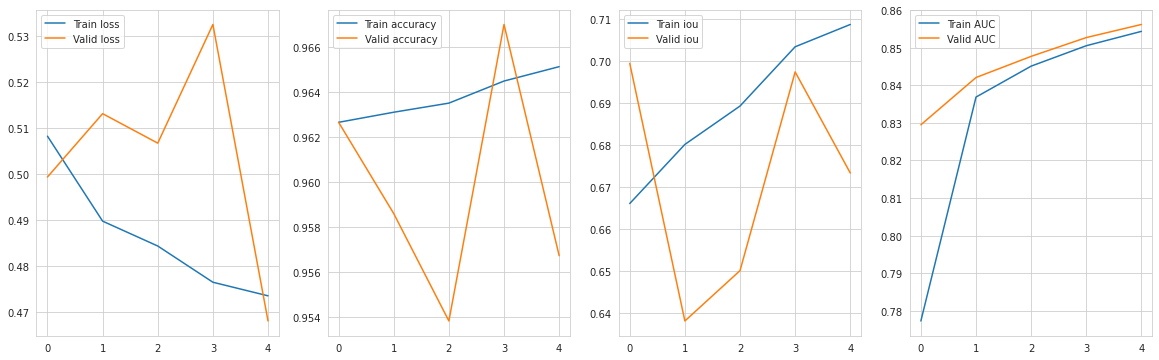

In [0]:
history = history3

plt.figure(figsize=(20,6)) 
plt.subplot(141) 
plt.plot(history.epoch, history.history["loss"], label="Train loss") 
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss") 
plt.legend() 
plt.subplot(142) 
plt.plot(history.epoch, history.history["accuracy"], label="Train accuracy") 
plt.plot(history.epoch, history.history["val_accuracy"], label="Valid accuracy") 
plt.legend() 
plt.subplot(143) 
plt.plot(history.epoch, history.history["mean_iou"], label="Train iou") 
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou") 
plt.legend()
plt.subplot(144) 
plt.plot(history.epoch, history.history['auc_1'], label="Train AUC") 
plt.plot(history.epoch, history.history["val_auc_1"], label="Valid AUC")
plt.legend()

plt.show() 

In [0]:
# Get Training Loss, Accuracy from model history
df_regr_metrics = pd.DataFrame(columns=['Model','Epoch','Train loss','Valid loss','Train accuracy','Valid accuracy','Train iou','Valid iou','Train Precision','Valid Precision','Train Recall','Valid Recall','Train AUC','Valid AUC'])
for i, epoch_num in enumerate(history.epoch):
  df_regr_metrics = df_regr_metrics.append({
                    'Model':'Model3',
                    'Epoch': int(epoch_num),
                    'Train loss':history.history["loss"][i],
                    'Valid loss':history.history["val_loss"][i],
                    'Train accuracy':history.history["accuracy"][i],
                    'Valid accuracy':history.history["val_accuracy"][i],
                    'Train iou':history.history["mean_iou"][i],
                    'Valid iou':history.history["val_mean_iou"][i],
                    'Train Precision':history.history['precision_1'][i],
                    'Valid Precision':history.history["val_precision_1"][i],
                    'Train Recall':history.history['recall_1'][i],
                    'Valid Recall':history.history["val_recall_1"][i],
                    'Train AUC':history.history['auc_1'][i],
                    'Valid AUC':history.history["val_auc_1"][i]}, ignore_index=True)
# saving the dataframe   
df_regr_metrics.to_csv(project_path + 'model3_regr_metrics.csv') 

df_regr_metrics

Model Epoch  Train loss  ...  Valid Recall  Train AUC  Valid AUC
0  Model3     0    0.508168  ...      0.217154   0.777253   0.829495
1  Model3     1    0.489740  ...      0.246505   0.836875   0.842083
2  Model3     2    0.484346  ...      0.263637   0.845117   0.847719
3  Model3     3    0.476490  ...      0.276121   0.850551   0.852723
4  Model3     4    0.473541  ...      0.284979   0.854376   0.856212

[5 rows x 14 columns]

In [0]:
# Load regression YAML and create model
with open(project_path + 'model3.yaml', 'r') as yaml_file:
  loaded_model_yaml = yaml_file.read()
loaded_regr_model3 = model_from_yaml(loaded_model_yaml)
# Load weights into new model
loaded_regr_model3.load_weights(project_path + "model3_weights.h5")
print("Loaded regression model from disk")

# loaded_regr_model3.summary()

Loaded regression model from disk


####Model Selection

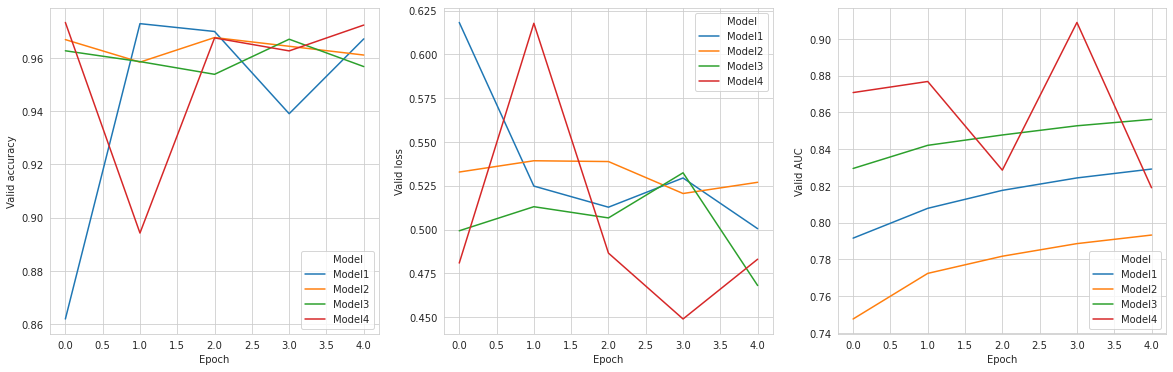

In [53]:
# Plot metrics for all the models
df_combined_model_metrics = pd.read_csv(project_path + 'combined_regr_metrics.csv') #<filename>)

sns.set_style("whitegrid")
plt.figure(figsize=(20,6)) 
plt.subplot(131) 
sns.lineplot(x='Epoch', y='Valid accuracy', hue='Model', data=df_combined_model_metrics)
plt.subplot(132) 
sns.lineplot(x='Epoch', y='Valid loss', hue='Model', data=df_combined_model_metrics)
plt.subplot(133) 
sns.lineplot(x='Epoch', y='Valid AUC', hue='Model', data=df_combined_model_metrics)

####Selected Model 3 to continue based on the Accuracy, IOU, AUC metrics

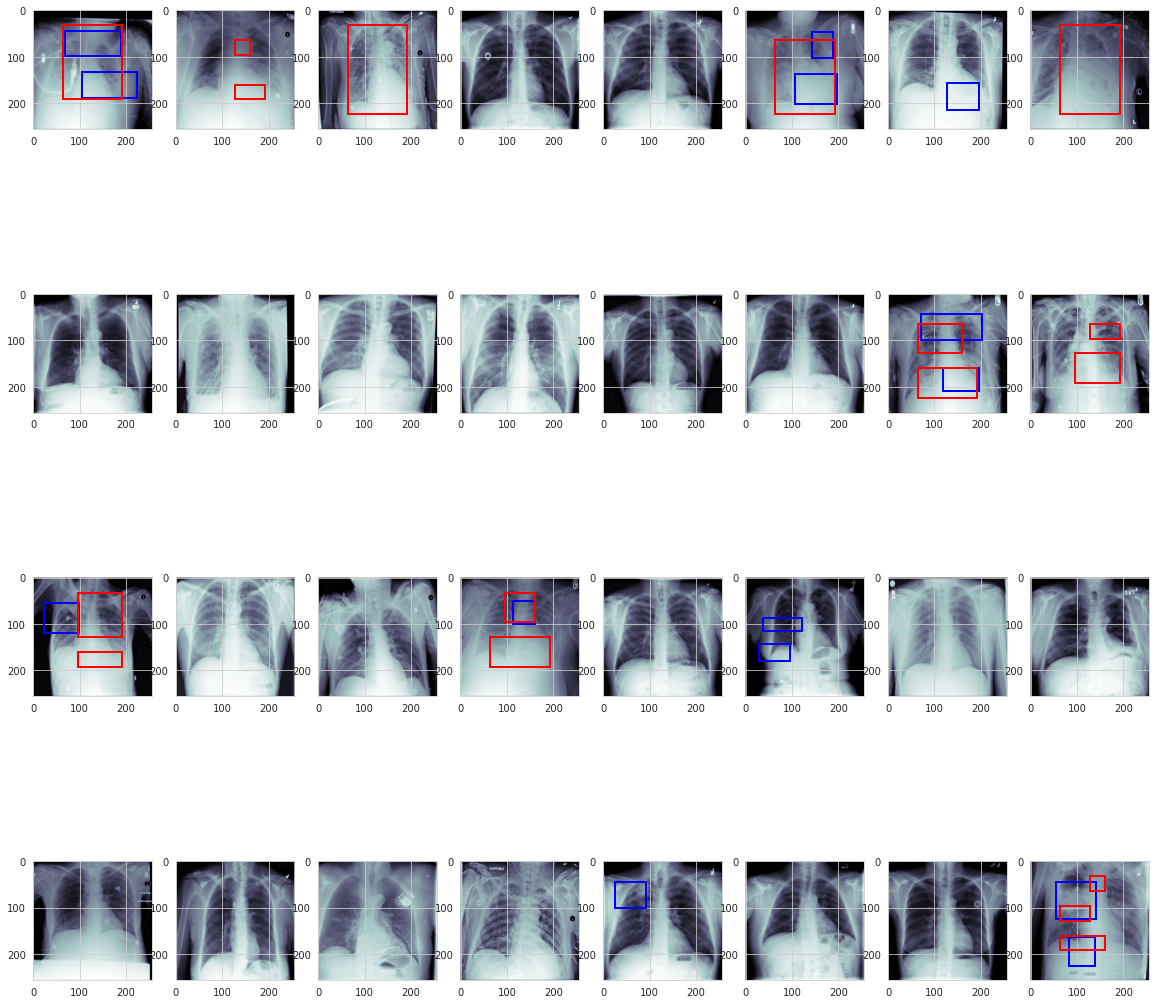

In [0]:
# Display the actual vs predicted bounding boxes
from skimage import measure
import matplotlib.patches as patches

model = model3 #loaded_regr_model3 # This is for model3

for imgs, msks in valid_gen: 
  # predict batch of images 
  preds = model.predict(imgs)

  # create figure 
  f, axarr = plt.subplots(4, 8, figsize=(20,20)) 
  axarr = axarr.ravel() 
  axidx = 0

  # Loop through batch 
  for img, msk, pred in zip(imgs, msks, preds): 
    # plot image 
    axarr[axidx].imshow(img[:, :, 0], cmap=plt.cm.bone) 

    # threshoLd true mask 
    comp = msk[:, :,0] > 0.5 
    # appLy connected components 
    comp = measure.label(comp) 
    # appLy bounding boxes 
    predictionString = ''
    for region in measure.regionprops(comp): 
      # retrieve x, y, height and width 
      y, x, y2, x2 = region.bbox 
      height = y2 - y 
      width = x2 - x 
      axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='b',facecolor='none')) 

    # threshold predicted mask 
    comp = pred[:, :, 0] > 0.5 
    # apply connected components 
    comp = measure.label(comp) 
    # apply bounding boxes 
    predictionString = '' 
    for region in measure.regionprops(comp): 
      # retrieve x, y, height and width 
      y, x, y2, x2 = region.bbox 
      height = y2 - y 
      width = x2 - x 
      axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='r',facecolor ='none')) 

    axidx += 1 
  plt.show() 
  # onLy plot one batch 
  break 

Submission File Creation

In [0]:
# Generate the test data for the entire testdata
folder = PATH + 'stage_2_test_images/'
test_filenames = os.listdir(folder)
print('n test samples', len(test_filenames))

# Set predict=True so the entire dataset is returned at once
test_gen = DataSequence(folder, test_filenames, pneumonia_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=False, predict=True) 

n test samples 3000


In [0]:
submission_dict = {}
# Predict the bbox coordinates for the test dataset and 
for imgs, filenames in test_gen: 
  # predict batch of images 
  preds = model.predict(imgs)

  for filename, pred in zip(filenames, preds):
    # resize predicted mask
    pred = resize(pred, (1024, 1024), mode='reflect')
    # threshold predicted mask 
    comp = pred[:, :, 0] > 0.5 
    # apply connected components 
    comp = measure.label(comp) 
    # apply bounding boxes 
    predictionString = '' 
    for region in measure.regionprops(comp): 
      # retrieve x, y, height and width 
      y, x, y2, x2 = region.bbox 
      height = y2 - y 
      width = x2 - x 
      # proxy for confidence score
      conf = np.mean(pred[y:y+height, x:x+width])
      predictionString += str(conf) + ' ' + str(x) + ' ' + str(y) + ' ' + str(width) + ' ' + str(height) + ' '
    filename = filename.split('.')[0]
    submission_dict[filename] = predictionString  
  # stop if we've got them all
  if len(submission_dict) >= len(test_filenames):
    break

# save dictionary as csv file
sub = pd.DataFrame.from_dict(submission_dict, orient='index')
sub.index.names = ['patientId']
sub.columns = ['PredictionString']
sub.to_csv(project_path+'submission.csv')

Analysis of Predictions

In [0]:
# Read submission data into a dataframe for some further analysis
submission_df = pd.read_csv(project_path+'submission.csv')
submission_df.head()

patientId                                   PredictionString
0  1f5f2bb2-acc2-4c18-b6d5-212f9a9980b5                         0.8088797 255 256 513 514 
1  0cfcd755-5c79-4fcd-9562-0b983f77d0c0                                                NaN
2  1a0309e4-762b-4b64-9e2c-0f16dc4d5381                                                NaN
3  2b9990c6-dd10-44e4-9d5a-5701a964a57d                                                NaN
4  0066ba32-08b6-4ac9-8d5a-abec69825d53  0.59485024 510 129 129 254 0.58792937 386 640 ...

In [0]:
# Check how many patients are diagnosed with Pneumonia
temp = pd.DataFrame(submission_df.groupby(submission_df['PredictionString'].notnull())['patientId'].count())
temp.columns = ['Count of Patients']
print(temp)

print('\nPatients that may have pneumonia: {:0.2f}%'.format(935/3000))

# Out of 3000 patients in the test set, 935 appear to have pneumonia for whom one or more bounding boxes are predicted by our model.
# Approximately 31% of patients are predicted to have pneumonia which is consistent with the training set data.

                  Count of Patients
PredictionString                   
False                          2065
True                            935

Patients that may have pneumonia: 0.31


In [0]:
# Take a sample of images from the test set and plot the predicted bounding boxes on them
# This dataframe is to hold sample filenames
search_values = ['1f5f2bb2-acc2-4c18-b6d5-212f9a9980b5','0066ba32-08b6-4ac9-8d5a-abec69825d53','2b9990c6-dd10-44e4-9d5a-5701a964a57d']
data = submission_df[submission_df.patientId.str.contains('|'.join(search_values))]
data

# Selected 1 image with no predicted bounding box, 1 with a single bounding box and the last one with 2 predicted bounding boxes.

patientId                                   PredictionString
0  1f5f2bb2-acc2-4c18-b6d5-212f9a9980b5                         0.8088797 255 256 513 514 
3  2b9990c6-dd10-44e4-9d5a-5701a964a57d                                                NaN
4  0066ba32-08b6-4ac9-8d5a-abec69825d53  0.59485024 510 129 129 254 0.58792937 386 640 ...

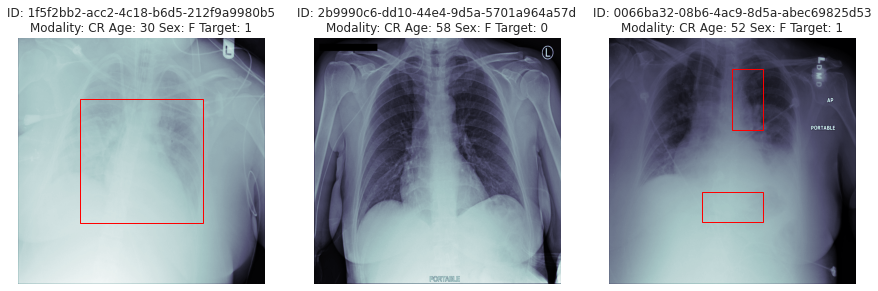

In [0]:
# This code is to plot the images for the above samples and their respective bounding boxes
img_data = list(data.T.to_dict().values())

f, ax = plt.subplots(1, 3, figsize=(15,5))
for i, data_row in enumerate(img_data):

  # Get the patient info from the dcm image and plot the image
  patid = data_row['patientId']
  img_file = patid + '.dcm'
  img = pydicom.dcmread(folder + img_file)
  modality = img.Modality
  age = img.PatientAge
  sex = img.PatientSex

  location = data_row['PredictionString']
  if pd.notnull(location):
    tgt = 1
  else:
    tgt = 0

  ax[i].imshow(img.pixel_array, cmap=plt.cm.bone)
  ax[i].axis('off')
  ax[i].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}'.format(patid, modality, age, sex, tgt))

  # If bounding boxes are predicted for the image, plot them on top of the image
  if pd.notnull(location):
    loc_list = location.split()
    l = len(loc_list)//5

    for j in range(l):
      x = int(loc_list[j+1+(4*j)])
      y = int(loc_list[j+2+(4*j)])
      wid = int(loc_list[j+3+(4*j)])
      hgt = int(loc_list[j+4+(4*j)])
      rect = patches.Rectangle((x,y),wid,hgt,linewidth=1,edgecolor='r',facecolor='none')
      ax[i].add_patch(rect)

plt.show()

As we can see, the model is predicting correctly.
*   For the first patient, the bounding box is bigger as the whole chest looks congested
*   For the second patient, we dont have a bounding box, as the lungs appear to be clear
*   For the third patient, pneumonia is detected in 2 different areas marked by the two seperate bounding boxes.



##Summary

*   Extracted and loaded data and performed EDA, preprocessing
*   Created 1 model for Pneumonia classification with 80.81% accuracy
*   Created 4 different custom models for object detection of increasing complexity and evaluated each based on accuracy and custom iou_bce_loss.
*   Picked Model3 for predicting with test data
*   Created submission file in .csv format with required columns and prediction string containing confidence and bbox coordinates
*   Plotted the actual and predicted bounding boxes on top of image for 1 batch of images

##Conclusion

Our model is able to predict the bounding boxes around Pneumonic patches with accuracy of 87% on test data.
Out of 3000 patients in the test set, 935 appear to have pneumonia for whom one or more bounding boxes are predicted by our model.
Approximately 31% of patients are predicted to have pneumonia which is consistent with the training set data.


This project uses recent techniques in the field of computer vision and deep learning and visualizations of key outcomes.
This project will help health care professionals by making quick and accurate predictions of pneumonia in CXR images.
